In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/graduate_project

/content/drive/My Drive/graduate_project


In [4]:
import os
import pandas
import numpy
import random
import copy
import time

import keras.utils.np_utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

from IPython.display import SVG

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import itertools

import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

Using TensorFlow backend.


In [0]:
CSV_PATH = r"""/content/drive/My Drive/graduate_project/Jfile"""
folder_list = os.listdir(CSV_PATH)
csv_list = list()



for file_name in folder_list:
    if file_name.split(".")[-1] == 'csv':
        f = open(CSV_PATH + "/" + file_name)
        temp_list = [f.read(), file_name.split(".")[0]]
        csv_list.append(temp_list)



def making_df_faster(csv_file_list, column_index=None, split_idx=1):
    
    if column_index == None:
        # column_index = numpy.arange(len(csv_file_list[0][0].split("\n")[0].split(",")))
        column_index = csv_file_list[0][0].split("\n")[0].split(",")
        column_index_2 = [item.replace('"', "") for item in column_index]
    column_index = numpy.hstack((column_index_2, "class_front", "class_back", 'class_combined'))
    
    result_df = pandas.DataFrame(columns=column_index)
    
    row_count = 0
    
    for csv_idx, csv_file in enumerate(csv_file_list):
        one_file_df = pandas.DataFrame(columns=column_index)
        for idx, line in enumerate(csv_file[0].split("\n")):
            if line != "" and idx != 0:
                one_file_df.loc[idx, one_file_df.columns[0]] = line.split(",")[0].replace('"', "")
                temp_data = numpy.array(line.split(",")[1:]).astype(numpy.float)
                temp_data[temp_data < 0] = 0
                one_file_df.loc[idx, one_file_df.columns[1:-3]] = temp_data
                one_file_df.loc[idx, 'class_front'] = int(csv_file[1].split("f")[0][split_idx:])
                one_file_df.loc[idx, 'class_back'] = int(csv_file[1].split("f")[1])
                one_file_df.loc[idx, 'class_combined'] = csv_file[1].split("f")[0][split_idx:] + "_" + csv_file[1].split("f")[1]
                                                           
                row_count += 1
            if row_count % 100 == 0:
                print(row_count)
        result_df = result_df.append(one_file_df)
        print(csv_idx, "th csv is combined complete \n\n\n\n")
    return result_df.reset_index(drop=True)


def deleting_non_detected_columns(given_df, final_data_type='float32'):
    str_df = given_df
#     str_df = None
#     if given_df.dtypes[1] != 'str':
#         str_df = given_df
#         str_df.loc[:, str_df.columns[1:]] = str_df.loc[:, str_df.columns[1:]].astype('str')
    
#     else:
#         str_df = given_df
    
    target_columns = str_df.describe().loc['unique', ][str_df.describe().loc['unique'] == 1].index
    
    for col in target_columns:
        str_df = str_df.drop(columns=col)
    
    final_df = str_df
    final_df.loc[:, final_df.columns[1:-3]] = final_df.loc[:, final_df.columns[1:-3]].astype(final_data_type)
    return final_df


def deleting_before_camera_set(given_df, desire_type='float32', target_column='class_combined', cutting_idx_rank=5):
    cal_df = given_df
#     cal_df = None
#     if given_df.dtypes[2] != desire_type:
#         cal_df = given_df
#         cal_df.loc[:, cal_df.columns[1:-3]] = cal_df.loc[:, cal_df.columns[1:-3]].astype(desire_type)
    
#     else:
#         cal_df = given_df
        
    final_df = pandas.DataFrame(columns=cal_df.columns)
    
    for cls in set(cal_df.loc[:, target_column]):
        max_value_idx_list = cal_df.loc[cal_df.loc[:, target_column] == cls].loc[:, cal_df.columns[3:-2:3]].astype('float32').idxmax()
        cutting_idx = max_value_idx_list.sort_values()[cutting_idx_rank]
        final_df = final_df.append(cal_df.loc[cal_df.loc[:, target_column] == cls][cutting_idx:])
    
    return final_df


def normalization_df(given_df, freq_threshold=0.2, z_axis_threshold=100):
    cal_df = given_df
    
    cls_list = given_df.columns
    df_analysis = given_df.describe(include=['freq', 'count'])
    
    threshold_col = df_analysis.loc['freq'][df_analysis.loc['freq'] > df_analysis.loc['count'] * freq_threshold]
    threshold_col = threshold_col.index
#     print(threshold_col.index)
    
    z_col = given_df.iloc[0, 1:-3] > z_axis_threshold
    z_col = z_col[z_col].index
    
    for col in threshold_col.to_list():
        cal_df.drop(columns=col)
    for col in z_col.to_list():
        cal_df.loc[:, col] = cal_df.loc[:, col] / cal_df.loc[:, col].max()
        
        
    return cal_df


def normalization_df_ver2(given_df):
    cal_df = given_df 
        
    z_df = cal_df.iloc[:, 3:-3:3]
    z_max = z_df.max()
    
    cal_df.iloc[:, 3:-3:3] = cal_df.iloc[:, 3:-3:3] / z_max
    return cal_df


def chunking_data(given_df, chunking_length=60, class_column_name='class_combined'):
    
    np_list = list()
    
    for cls in set(given_df.loc[:, class_column_name]):
        get_df = given_df[given_df.loc[:, class_column_name] == cls]
        np_list.append(get_df.to_numpy())
        
    chunked_data = list()
    chunked_label = list()
    for data in np_list:
        for idx in range(len(data) - chunking_length):
            chunked_data.append(numpy.array(data[idx:idx + chunking_length, 1:-3]))
            chunked_label.append(int(data[0, -3]))
    
    return numpy.array(chunked_data), np_utils.to_categorical(chunked_label)


def preprocessing(given_df, chk_len=60):
    print("deleting data before camera set")
    cal_df = deleting_before_camera_set(given_df)
    print("deleting data before camera set success\n\n")
    print("deleting undetected data")
    cal_df = deleting_non_detected_columns(cal_df)
    print("deleting undetected data done\n\n")
    print("normalizing data")
    cal_df = normalization_df_ver2(cal_df)
    print("normalizing data done \n\n")
    return chunking_data(cal_df, chk_len), cal_df

def making_df_faster_2(csv_file_list, column_index=None, split_idx=1):
    
    if column_index == None:
        # column_index = numpy.arange(len(csv_file_list[0][0].split("\n")[0].split(",")))
        column_index_2 = [idx + 1 for idx in range(len(csv_file_list[0][0].split("\n")[0].split(",")))]
#         column_index_2 = [item.replace('"', "") for item in column_index]
    column_index = numpy.hstack((column_index_2, "class_front", "class_back", 'class_combined'))
    
    result_df = pandas.DataFrame(columns=column_index)
    
    row_count = 0
    
    for csv_idx, csv_file in enumerate(csv_file_list):
        one_file_df = pandas.DataFrame(columns=column_index)
        for idx, line in enumerate(csv_file[0].split("\n")):
            if line != "" and idx != 0:
                one_file_df.loc[idx, one_file_df.columns[0]] = line.split(",")[0].replace('"', "")
#                 print(one_file_df, "\n" * 10, one_file_df.loc[idx, one_file_df.columns[1:]])
                temp_data = numpy.array(line.split(",")[1:]).astype(numpy.float)
                one_file_df.loc[idx, one_file_df.columns[1:-3]] = temp_data
                one_file_df.loc[idx, 'class_front'] = int(csv_file[1].split("f")[0][split_idx:])
                one_file_df.loc[idx, 'class_back'] = int(csv_file[1].split("f")[1])
                one_file_df.loc[idx, 'class_combined'] = csv_file[1].split("f")[0][split_idx:] + "_" + csv_file[1].split("f")[1]
                                                           
                row_count += 1
            if row_count % 100 == 0:
                print(row_count)
        result_df = result_df.append(one_file_df)
        print(csv_idx, "th csv is combined complete \n\n\n\n")
    return result_df.reset_index(drop=True)


In [6]:
df_faster_version = making_df_faster(csv_list)

0
0 th csv is combined complete 




100
1 th csv is combined complete 




200
2 th csv is combined complete 




300
3 th csv is combined complete 




400
4 th csv is combined complete 




500
5 th csv is combined complete 




6 th csv is combined complete 




600
7 th csv is combined complete 




700
8 th csv is combined complete 




800
9 th csv is combined complete 




900
10 th csv is combined complete 




1000
11 th csv is combined complete 




1100
12 th csv is combined complete 




1200
13 th csv is combined complete 




1300
14 th csv is combined complete 




15 th csv is combined complete 




1400
1500
16 th csv is combined complete 




1600
17 th csv is combined complete 




18 th csv is combined complete 




1700
19 th csv is combined complete 




1800
20 th csv is combined complete 




1900
21 th csv is combined complete 




2000
22 th csv is combined complete 




2100
23 th csv is combined complete 




2200
24 th csv is combined complete 




25 th c

In [7]:
# 학부생 데이터
csv_list_2 = list()
CSV_PATH_2 = r"""/content/drive/My Drive/graduate_project/Gfile"""

for file_name in os.listdir(CSV_PATH_2):
    if file_name.split(".")[-1] == 'csv':
        f = open(CSV_PATH_2 + "/" + file_name)
        temp_list = [f.read(), file_name.split(".")[0]]
        csv_list_2.append(temp_list)

        

df_faster_gfile = making_df_faster_2(csv_list_2, split_idx=2)

0
100
0 th csv is combined complete 




200
1 th csv is combined complete 




300
2 th csv is combined complete 




400
3 th csv is combined complete 




500
4 th csv is combined complete 




600
5 th csv is combined complete 




700
6 th csv is combined complete 




800
900
7 th csv is combined complete 




1000
8 th csv is combined complete 




1100
9 th csv is combined complete 




1200
10 th csv is combined complete 




1300
11 th csv is combined complete 




1400
12 th csv is combined complete 




1500
13 th csv is combined complete 




1600
1700
14 th csv is combined complete 




1800
15 th csv is combined complete 




1900
16 th csv is combined complete 




2000
17 th csv is combined complete 




2100
18 th csv is combined complete 




2200
19 th csv is combined complete 




2300
20 th csv is combined complete 




2400
2500
21 th csv is combined complete 




2600
22 th csv is combined complete 




2700
23 th csv is combined complete 




2800
24 th csv is 

In [9]:
target_joint = ['shoulder', 'elbow', 'wrist']
joint_name = df_faster_version.columns.to_numpy()

temp_array = list()
for joint in joint_name:
    joint_flag = False
    for target in target_joint:
        if target in joint:
            temp_array.append(True)
            joint_flag = True
    if not joint_flag:
        temp_array.append(False)
        
joint_name[temp_array]

array(['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_wrist_x',
       'left_wrist_y', 'left_wrist_z', 'right_shoulder_x',
       'right_shoulder_y', 'right_shoulder_z', 'right_elbow_x',
       'right_elbow_y', 'right_elbow_z', 'right_wrist_x', 'right_wrist_y',
       'right_wrist_z', 'v_left_shoulder_x', 'v_left_shoulder_y',
       'v_left_shoulder_z', 'v_left_elbow_x', 'v_left_elbow_y',
       'v_left_elbow_z', 'v_left_wrist_x', 'v_left_wrist_y',
       'v_left_wrist_z', 'v_right_shoulder_x', 'v_right_shoulder_y',
       'v_right_shoulder_z', 'v_right_elbow_x', 'v_right_elbow_y',
       'v_right_elbow_z', 'v_right_wrist_x', 'v_right_wrist_y',
       'v_right_wrist_z', 'a_left_shoulder_x', 'a_left_shoulder_y',
       'a_left_shoulder_z', 'a_left_elbow_x', 'a_left_elbow_y',
       'a_left_elbow_z', 'a_left_wrist_x', 'a_left_wrist_y',
       'a_left_wrist_z', 'a_right_shoulder_x', 'a_right_shoulder_y',
       'a_righ

In [0]:
joint_base = list(joint_name[temp_array])
joint_base.extend(joint_name[-3:])

target_df = df_faster_version.loc[:, joint_base]
target_df.iloc[:, 2:-3:3] = target_df.iloc[:, 2:-3:3] / numpy.max(target_df.iloc[:, 2:-3:3].to_numpy())

time_target_df = target_df
np_time = df_faster_version.loc[:, 'time'].to_numpy()
np_time_split = [item.split(":") for item in np_time]
np_time_sum = [3600*int(time[0]) + 60*int(time[1]) + float(time[2]) for time in np_time_split]

In [0]:
# Extracted Joint Coordinates(Left/Right Sho/Elb/Wrist) /Velocity/Acceleration
joint_base = list(joint_name[temp_array])
joint_base.extend(joint_name[-3:])

target_df = df_faster_version.loc[:, joint_base]

In [0]:
target_df.iloc[:, 2:-3:3] = target_df.iloc[:, 2:-3:3] / numpy.max(target_df.iloc[:, 2:-3:3].to_numpy())

In [0]:
# time data 
time_target_df = target_df
np_time = df_faster_version.loc[:, 'time'].to_numpy()
np_time_split = [item.split(":") for item in np_time]
np_time_sum = [3600*int(time[0]) + 60*int(time[1]) + float(time[2]) for time in np_time_split]
time_target_df['time'] = np_time_sum

In [14]:
# Add time data into table
time_target_df.head()

,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_elbow_x,left_elbow_y,left_elbow_z,left_wrist_x,left_wrist_y,left_wrist_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,right_elbow_x,right_elbow_y,right_elbow_z,right_wrist_x,right_wrist_y,right_wrist_z,v_left_shoulder_x,v_left_shoulder_y,v_left_shoulder_z,v_left_elbow_x,v_left_elbow_y,v_left_elbow_z,v_left_wrist_x,v_left_wrist_y,v_left_wrist_z,v_right_shoulder_x,v_right_shoulder_y,v_right_shoulder_z,v_right_elbow_x,v_right_elbow_y,v_right_elbow_z,v_right_wrist_x,v_right_wrist_y,v_right_wrist_z,a_left_shoulder_x,a_left_shoulder_y,a_left_shoulder_z,a_left_elbow_x,a_left_elbow_y,a_left_elbow_z,a_left_wrist_x,a_left_wrist_y,a_left_wrist_z,a_right_shoulder_x,a_right_shoulder_y,a_right_shoulder_z,a_right_elbow_x,a_right_elbow_y,a_right_elbow_z,a_right_wrist_x,a_right_wrist_y,a_right_wrist_z,class_front,class_back,class_combined,time
0,0.567229,0.447312,0.877501,0.580508,0.530268,0.881663,0,0,0,0.512439,0.455667,0.936357,0,0,0,0,0,0,0,0.0411296,6.64308e-08,0,0.0725504,0,0,0,0,0,1.18189,0,0,0,0,0,0,0,0,0.0428114,3.21698e-09,0,0.0194355,0,0,0,0,0,0.0202868,0,0,0,0,0,0,0,10,2,10_2,62119.686
1,0.568954,0.443284,0.874823,0.580922,0.527016,0.877614,0,0,0,0.528089,0.456153,0.943176,0,0,0,0,0,0,0,0,3.71007e-09,0,0,0,0,0,0,1.47273e-05,0.698701,0,0,0,0,0,0,0,0,0,0,7.10744e-07,0,0,0,0,0,5.26143e-06,0,0,0,0,0,0,0,0,10,2,10_2,62119.719
2,0.56173,0.440688,0.857762,0.580588,0.52271,0.867989,0,0,0,0.531783,0.457574,0.939266,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.17941e-05,0,0,0,0,0,0,0,0,1.34434e-06,0,0,0,0,0,0,0,0,7.96084e-07,0,0,0,0,0,0,0,0,10,2,10_2,62119.753
3,0.568548,0.434956,0.863159,0.577355,0.520596,0.868416,0,0,0,0.528513,0.445758,0.944457,0,0,0,0,0,0,0,0.553038,0,0,0.0437086,0,0,0,0,0,0.531923,0,0,0,0,0,0,0,0,0.068178,0,1.89656e-06,0.0303324,0,0,0,0,0,0.0279023,0,0,0,0,0,0,0,10,2,10_2,62119.786
4,0.571182,0.437023,0.868843,0.578024,0.523212,0.871759,0,0,0,0.530657,0.456083,0.939106,0,0,0,0,0,0,6.45937e-05,0.600586,6.1826e-09,8.175e-05,0.353317,0,0,0,0,0.000322656,0,0,0,0,0,0,0,0,7.44658e-06,0.00148588,1.0986e-09,4.55658e-06,0.00967527,0,0,0,0,2.12724e-05,0,0,0,0,0,0,0,0,10,2,10_2,62119.818


In [0]:
def calculate_velo_accele(given_df, columns_length=18):
    if 'time' not in list(given_df.columns):
        raise Exception("DataFrame should have 'time' column. Check Dataframe")
    
    class_comb = numpy.unique(given_df.loc[:, 'class_combined'].to_numpy())
    
    cal_np = given_df.to_numpy()
    velo_final_data = list()
    accele_final_data = list()
    position_final_data = list()
    etc_final_data = list()
    
    for idx, cls in enumerate(class_comb):
        temp_data = cal_np[cal_np[:, -2] == cls]
        temp_time = temp_data[1:, -1] - temp_data[:-1, -1]
        final_time = numpy.repeat(temp_time, columns_length).reshape((-1, temp_data.shape[0] - 1, columns_length))
        
        position_data = temp_data[2:, :columns_length]
        etc_data = temp_data[2:, columns_length*3:-1]
        
        velo_data = (temp_data[1:, :columns_length] - temp_data[:-1, :columns_length]) / final_time
        cp_velo = copy.deepcopy(velo_data)
        accele_data = (cp_velo[:, 1:] - cp_velo[:, :-1]) / final_time[0][1:]

        
        velo_final_data.extend(list(velo_data[0][1:]))
        accele_final_data.extend(list(accele_data[0]))
        position_final_data.extend(list(position_data))
        etc_final_data.extend(etc_data)
    temp_sum_data = numpy.hstack((
                                  numpy.array(velo_final_data) / numpy.max(velo_final_data),
                                  numpy.array(accele_final_data) / numpy.max(accele_final_data),
                                  etc_final_data))

    return pandas.DataFrame(temp_sum_data, columns=given_df.columns[columns_length:-1])

In [17]:
# Check Velocity and Acceleration data
calculated_df = calculate_velo_accele(target_df)
calculated_df.head()

,v_left_shoulder_x,v_left_shoulder_y,v_left_shoulder_z,v_left_elbow_x,v_left_elbow_y,v_left_elbow_z,v_left_wrist_x,v_left_wrist_y,v_left_wrist_z,v_right_shoulder_x,v_right_shoulder_y,v_right_shoulder_z,v_right_elbow_x,v_right_elbow_y,v_right_elbow_z,v_right_wrist_x,v_right_wrist_y,v_right_wrist_z,a_left_shoulder_x,a_left_shoulder_y,a_left_shoulder_z,a_left_elbow_x,a_left_elbow_y,a_left_elbow_z,a_left_wrist_x,a_left_wrist_y,a_left_wrist_z,a_right_shoulder_x,a_right_shoulder_y,a_right_shoulder_z,a_right_elbow_x,a_right_elbow_y,a_right_elbow_z,a_right_wrist_x,a_right_wrist_y,a_right_wrist_z,class_front,class_back,class_combined
0,-0.00100718,0.00248253,-0.00475848,0.00350922,0.00548047,7.56111e-06,0.00188089,0.00470737,-0.00479822,0.000270019,0.00529053,0.00100864,6.77615e-05,0.00732851,0.00271541,0.00062012,0.000554412,-0.00444397,-0.0010056,0.00147269,-0.00356059,0.000749617,0.00469157,0.00207841,0.00226363,0.00363592,-0.00155086,0.000844051,0.00335043,0.000805995,0.000125783,0.00593796,0.00418262,0.000122773,0.00105606,-0.000828543,10,1,10_1
1,-0.00659545,0.00965827,-0.0105457,-0.00496014,0.0108667,-0.00685395,0.00217853,0.0113997,-0.00186872,0.00196395,0.010669,-0.00105716,-0.00045739,0.0102365,-0.00468402,0.0102252,0.00386918,-0.00992015,-0.00529188,0.00679516,-0.0054803,-0.00802018,0.00510055,-0.0064976,0.000281851,0.00633743,0.00277413,0.00160409,0.00509326,-0.00195623,-0.000497299,0.00275376,-0.00700699,0.00909566,0.00313896,-0.00518575,10,1,10_1
2,-0.00209955,0.00346748,-0.0031532,0.00286822,0.00297727,-0.00103198,-0.0301464,-0.156137,0.000412181,0.00399157,0.011457,0.00162266,-0.00210908,0.0103103,0.000981758,0.00656969,0.0010376,-0.00271098,0.00399136,-0.00549604,0.00656292,0.00694984,-0.00700405,0.00516861,-0.0286974,-0.148736,0.00202493,0.00180008,0.000699515,0.00237908,-0.00146633,6.55462e-05,0.00502996,-0.00324529,-0.00251382,0.00640015,10,1,10_1
3,0.000463959,0.00287641,0.00147435,5.73898e-05,0.00256249,-0.00251028,-0.00697183,0.00689992,-0.00159146,-0.00253207,-0.00361418,0.000898696,0.000959724,-0.00337494,0.000557729,-0.0170372,-0.0147575,-0.00447381,0.00148625,-0.00034269,0.00268293,-0.00162964,-0.000240478,-0.000857077,0.013436,0.0945246,-0.00116166,-0.00378223,-0.00873786,-0.000419734,0.00177921,-0.00793435,-0.000245841,-0.0136866,-0.00915757,-0.00102204,10,1,10_1
4,0.00453684,-0.0126534,-0.00131773,0.00113183,-0.0115512,0.00376383,-0.0100668,0.0114866,-0.0149942,0.00222342,0.00522187,-0.00702305,-0.00260458,0.00638017,-7.97299e-05,-0.00878358,-0.0224481,-0.00133944,0.00361582,-0.013787,-0.00247874,0.000953863,-0.0125298,0.00557001,-0.00274766,0.00407198,-0.0118987,0.00422182,0.00784445,-0.00703276,-0.00316431,0.00866037,-0.000565922,0.00732736,-0.00682757,0.00278263,10,1,10_1


In [0]:
# Export from raw data Gfile(학부데이터)
np_df_ver2 = df_faster_gfile.to_numpy()
temp_np = np_df_ver2[np_df_ver2[:, -3] == 10]
temp_np = temp_np[temp_np[:, 0] != '0']
temp_df = pandas.DataFrame(temp_np)
df_faster_gfile.loc[np_df_ver2[:, 0] == temp_np[0][0], :].to_numpy()[0][1:-3]
df_faster_version.loc[df_faster_version.to_numpy()[:, 0] == temp_np[0][0]].to_numpy()[0][62:-3]
target_time_np = df_faster_version.loc[df_faster_version.to_numpy()[:, 0] == temp_np[0][0]].to_numpy()[0]

In [0]:
# Position Data(JC), Velocity, Acceleration 데이터 나누기
position_data = target_df.iloc[:, :18]
velocity_data = target_df.iloc[:, 18:36]
acceleration_data = target_df.iloc[:, 36:]

In [0]:
velocity_data[joint_name[-3:]] = df_faster_version.iloc[:, -3:]
position_data[joint_name[-3:]] = df_faster_version.iloc[:, -3:]

In [0]:
# Chunking data
position_total_data = chunking_data(position_data, 30)
all_feature_total_data = chunking_data(calculated_df, 30)

In [0]:
model_all_feature_shape = all_feature_total_data[0].shape[1:]
random_index = [i for i in range(all_feature_total_data[0].shape[0])]
random.shuffle(random_index)
np_ran_idx = numpy.array(random_index)

training_ratio = 0.5
test_ratio = 0.2

training_index = list(np_ran_idx[:int(np_ran_idx.shape[0] * training_ratio)])
validation_index = list(np_ran_idx[int(np_ran_idx.shape[0] * training_ratio):-int(np_ran_idx.shape[0] * test_ratio)])

In [0]:
# model_position_shape = (1, *position_total_data[0].shape[1:])
model_position_shape = position_total_data[0].shape[1:]

In [0]:
def plotting_history_loss(given_history, title='Loss graph'):
    fontP = FontProperties()
    plt.plot(given_history.history['loss'])
    plt.plot(given_history.history['val_loss'])
    plt.legend(['loss', 'val_loss'], prop=fontP, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(title)
    plt.show()
    
    
def plotting_history_acc(given_history, title='Accruacy graph'):
    fontP = FontProperties()
    plt.plot(given_history.history['acc'])
    plt.plot(given_history.history['val_acc'])
    plt.legend(['acc', 'val_acc'], prop=fontP, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(title)
    plt.show()

Model(LSTM)

**50_epoch**

In [0]:
lstm_model_position = Sequential()
lstm_model_position.add(LSTM(128, activation='relu', input_shape=model_position_shape))
lstm_model_position.add(Dense(256, activation='relu'))
lstm_model_position.add(Dense(256, activation='relu'))
lstm_model_position.add(Dense(position_total_data[1].shape[-1], activation='relu'))

lstm_model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jc_lstm_50_history.csv', append=True, separator=';')

position_history = lstm_model_position.fit(position_total_data[0][training_index], position_total_data[1][training_index],
                                      epochs= 50,
                                      validation_data=(position_total_data[0][validation_index],
                                                       position_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_position.to_json()
with open("./model_save/jc_lstm_model_50.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_position.save_weights("./model_save/jc_lstm_weight_50.h5")
print("Saved jc lstm model to disk")


lstm_model_speed = Sequential()
lstm_model_speed.add(LSTM(128, activation='relu', input_shape=model_all_feature_shape))
lstm_model_speed.add(Dense(256, activation='relu'))
lstm_model_speed.add(Dense(256, activation='relu'))
lstm_model_speed.add(Dense(all_feature_total_data[1].shape[-1], activation='relu'))

lstm_model_speed.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])


from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jcs_lstm_50_history.csv', append=True, separator=';')

lstm_speed_history = lstm_model_speed.fit(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],
                                            epochs=50,
                                            validation_data=(all_feature_total_data[0][validation_index],
                                                             all_feature_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_speed.to_json()
with open("./model_save/jcs_lstm_model_50.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_speed.save_weights("./model_save/jcs_lstm_weight_50.h5")
print("Saved jc lstm model to disk")


JC_loss = plotting_history_loss(position_history, 'JC lstm loss graph')
JCS_loss = plotting_history_loss(lstm_speed_history, 'JCS lstm loss graph')

JC_1dcnn_acc = plotting_history_acc(position_history, 'JC lstm Acc graph')
JCS_1dcnn_acc = plotting_history_acc(lstm_speed_history, 'JCS lstm Acc graph')

from sklearn.metrics import classification_report

# JC_training
print(classification_report(numpy.argmax(position_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(position_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][validation_index]), axis=1)))
# JCS_training
print(classification_report(numpy.argmax(all_feature_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(all_feature_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][validation_index]), axis=1)))

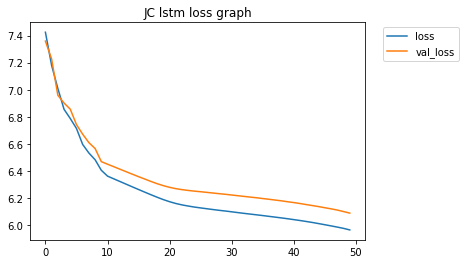

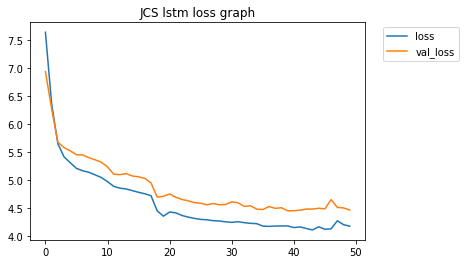

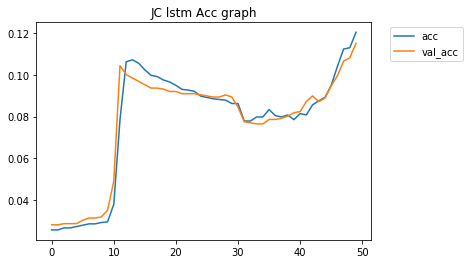

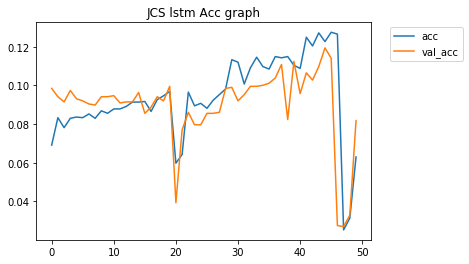

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          10       0.00      0.00      0.00        98
          11       0.00      0.00      0.00        75
          12       0.00      0.00      0.00        69
          13       0.42      0.16      0.23       116
          14       0.41      0.15      0.22        85
          15       0.00      0.00      0.00        56
          16       0.00      0.00      0.00        66
          17       0.33      0.16      0.21       103
          18       0.00      0.00      0.00        69
          19       0.00      0.00      0.00        70
          20       0.00      0.00      0.00        99
          21       0.29      0.03      0.05        67
          22       0.00      0.00      0.00        53
          23       0.00      0.00      0.00        94
          24       0.00      0.00      0.00        66
          25       0.00      0.00      0.00        96
          26       0.00      0.00      0.00        45
          27       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           6       0.00      0.00      0.00         0
          10       0.00      0.00      0.00       102
          11       0.00      0.00      0.00        81
          12       0.00      0.00      0.00        64
          13       0.17      0.04      0.06       108
          14       0.67      0.48      0.56        88
          15       0.82      0.09      0.16       101
          16       0.00      0.00      0.00        61
          17       0.00      0.00      0.00       104
          18       0.00      0.00      0.00        72
          19       0.00      0.00      0.00        68
          20       0.00      0.00      0.00        91
          21       0.18      0.02      0.04        81
          22       0.03      0.81      0.06        63
          23       0.00      0.00      0.00        81
          24       0.00      0.00      0.00        61
          25       0.12      0.01      0.02       100
          26       0.00    

**Epoch 100**

Train on 3096 samples, validate on 1858 samples
Epoch 1/100
3096/3096 [==============================] - 8s 2ms/step - loss: 8.3067 - acc: 0.0417 - val_loss: 8.2748 - val_acc: 0.0404
Epoch 2/100
3096/3096 [==============================] - 4s 1ms/step - loss: 7.8041 - acc: 0.0430 - val_loss: 8.0372 - val_acc: 0.0404
Epoch 3/100
3096/3096 [==============================] - 4s 1ms/step - loss: 7.6070 - acc: 0.0417 - val_loss: 7.7948 - val_acc: 0.0398
Epoch 4/100
3096/3096 [==============================] - 4s 1ms/step - loss: 7.4388 - acc: 0.0430 - val_loss: 7.7025 - val_acc: 0.0409
Epoch 5/100
3096/3096 [==============================] - 4s 1ms/step - loss: 7.3547 - acc: 0.0436 - val_loss: 7.6209 - val_acc: 0.0409
Epoch 6/100
3096/3096 [==============================] - 4s 1ms/step - loss: 7.2795 - acc: 0.0455 - val_loss: 7.5536 - val_acc: 0.0431
Epoch 7/100
3096/3096 [==============================] - 4s 1ms/step - loss: 7.2379 - acc: 0.0475 - val_loss: 7.4938 - val_acc: 0.0463
Epoch 8

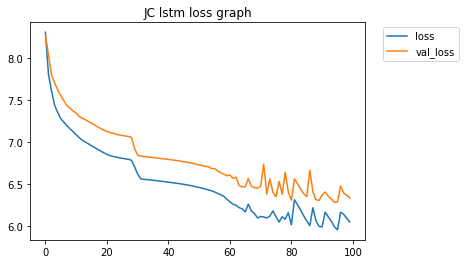

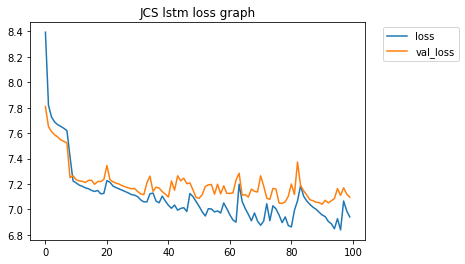

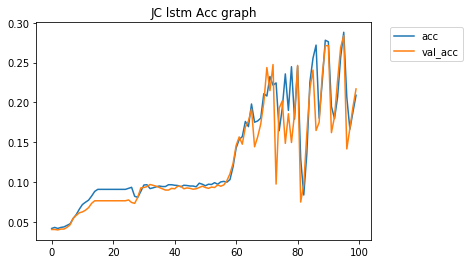

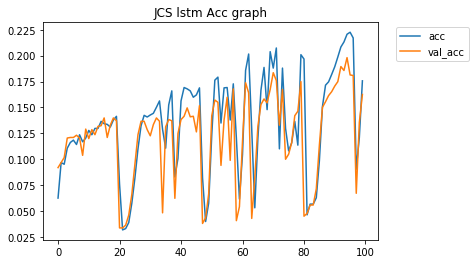

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          10       0.00      0.00      0.00        98
          11       0.00      0.00      0.00        75
          12       0.00      0.00      0.00        69
          13       0.82      0.12      0.21       116
          14       0.63      0.62      0.63        85
          15       0.00      0.00      0.00        56
          16       0.00      0.00      0.00        66
          17       0.30      0.37      0.33       103
          18       0.00      0.00      0.00        69
          19       0.11      0.10      0.10        70
          20       0.00      0.00      0.00        99
          21       0.00      0.00      0.00        67
          22       0.56      0.34      0.42        53
          23       0.82      0.99      0.90        94
          24       0.43      0.92      0.59        66
          25       0.00      0.00      0.00        96
          26       0.00      0.00      0.00        45
          27       0.88    

In [0]:
lstm_model_position = Sequential()
lstm_model_position.add(LSTM(128, activation='relu', input_shape=model_position_shape))
lstm_model_position.add(Dense(256, activation='relu'))
lstm_model_position.add(Dense(256, activation='relu'))
lstm_model_position.add(Dense(position_total_data[1].shape[-1], activation='relu'))

lstm_model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jc_lstm_100_history.csv', append=True, separator=';')

position_history = lstm_model_position.fit(position_total_data[0][training_index], position_total_data[1][training_index],
                                      epochs= 100,
                                      validation_data=(position_total_data[0][validation_index],
                                                       position_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_position.to_json()
with open("./model_save/jc_lstm_model_100.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_position.save_weights("./model_save/jc_lstm_weight_100.h5")
print("Saved jc lstm model to disk")


lstm_model_speed = Sequential()
lstm_model_speed.add(LSTM(128, activation='relu', input_shape=model_all_feature_shape))
lstm_model_speed.add(Dense(256, activation='relu'))
lstm_model_speed.add(Dense(256, activation='relu'))
lstm_model_speed.add(Dense(all_feature_total_data[1].shape[-1], activation='relu'))

lstm_model_speed.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jcs_lstm_100_history.csv', append=True, separator=';')

lstm_speed_history = lstm_model_speed.fit(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],
                                            epochs=100,
                                            validation_data=(all_feature_total_data[0][validation_index],
                                                             all_feature_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_speed.to_json()
with open("./model_save/jcs_lstm_model_100.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_speed.save_weights("./model_save/jcs_lstm_weight_100.h5")
print("Saved jc lstm model to disk")

JC_loss = plotting_history_loss(position_history, 'JC lstm loss graph')
JCS_loss = plotting_history_loss(lstm_speed_history, 'JCS lstm loss graph')

JC_1dcnn_acc = plotting_history_acc(position_history, 'JC lstm Acc graph')
JCS_1dcnn_acc = plotting_history_acc(lstm_speed_history, 'JCS lstm Acc graph')

from sklearn.metrics import classification_report

# JC_training
print(classification_report(numpy.argmax(position_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(position_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][validation_index]), axis=1)))
# JCS_training
print(classification_report(numpy.argmax(all_feature_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(all_feature_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][validation_index]), axis=1)))

**Epoch 150**

Train on 3096 samples, validate on 1858 samples
Epoch 1/150
3096/3096 [==============================] - 9s 3ms/step - loss: 8.6222 - acc: 0.0236 - val_loss: 7.9344 - val_acc: 0.0221
Epoch 2/150
3096/3096 [==============================] - 4s 1ms/step - loss: 7.5290 - acc: 0.0236 - val_loss: 7.0364 - val_acc: 0.0221
Epoch 3/150
3096/3096 [==============================] - 4s 1ms/step - loss: 6.7608 - acc: 0.0236 - val_loss: 6.7149 - val_acc: 0.0221
Epoch 4/150
3096/3096 [==============================] - 4s 1ms/step - loss: 6.6089 - acc: 0.0233 - val_loss: 6.6441 - val_acc: 0.0215
Epoch 5/150
3096/3096 [==============================] - 4s 1ms/step - loss: 6.5540 - acc: 0.0229 - val_loss: 6.6022 - val_acc: 0.0215
Epoch 6/150
3096/3096 [==============================] - 5s 1ms/step - loss: 6.5031 - acc: 0.0229 - val_loss: 6.5296 - val_acc: 0.0188
Epoch 7/150
3096/3096 [==============================] - 4s 1ms/step - loss: 6.4533 - acc: 0.0284 - val_loss: 6.4930 - val_acc: 0.0291
Epoch 8

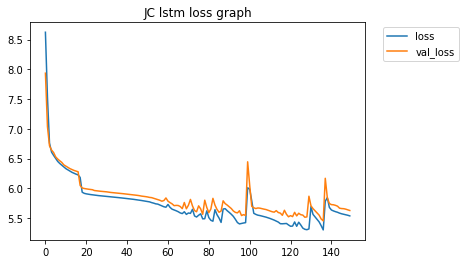

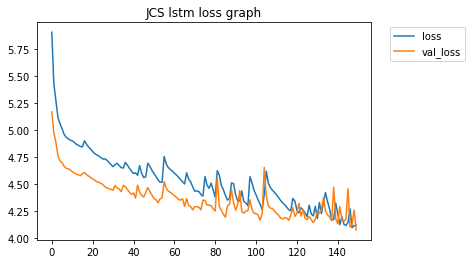

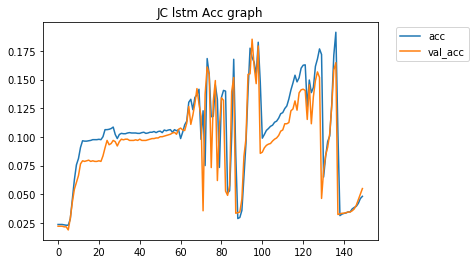

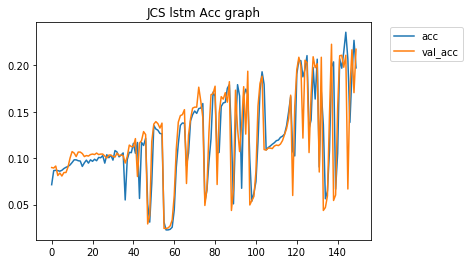

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          10       0.00      0.00      0.00        98
          11       0.00      0.00      0.00        75
          12       0.00      0.00      0.00        69
          13       0.00      0.00      0.00       116
          14       0.03      1.00      0.07        85
          15       0.00      0.00      0.00        56
          16       0.03      0.03      0.03        66
          17       0.70      0.07      0.12       103
          18       0.00      0.00      0.00        69
          19       0.00      0.00      0.00        70
          20       0.00      0.00      0.00        99
          21       0.25      0.01      0.03        67
          22       0.00      0.00      0.00        53
          23       1.00      0.13      0.23        94
          24       0.00      0.00      0.00        66
          25       0.00      0.00      0.00        96
          26       0.00      0.00      0.00        45
          27       0.00    

In [0]:
# LSTM model (JC)
lstm_model_position = Sequential()
lstm_model_position.add(LSTM(128, activation='relu', input_shape=model_position_shape))
lstm_model_position.add(Dense(256, activation='relu'))
lstm_model_position.add(Dense(256, activation='relu'))
lstm_model_position.add(Dense(position_total_data[1].shape[-1], activation='relu'))

lstm_model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jc_lstm_150_history.csv', append=True, separator=';')

position_history = lstm_model_position.fit(position_total_data[0][training_index], position_total_data[1][training_index],
                                      epochs= 150,
                                      validation_data=(position_total_data[0][validation_index],
                                                       position_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_position.to_json()
with open("./model_save/jc_lstm_model_150.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_position.save_weights("./model_save/jc_lstm_weight_150.h5")
print("Saved jc lstm model to disk")

###################################################################################################################################
# LSTM model (JCS)
lstm_model_speed = Sequential()
lstm_model_speed.add(LSTM(128, activation='relu', input_shape=model_all_feature_shape))
lstm_model_speed.add(Dense(256, activation='relu'))
lstm_model_speed.add(Dense(256, activation='relu'))
lstm_model_speed.add(Dense(all_feature_total_data[1].shape[-1], activation='relu'))

lstm_model_speed.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jcs_lstm_150_history.csv', append=True, separator=';')

lstm_speed_history = lstm_model_speed.fit(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],
                                            epochs=150,
                                            validation_data=(all_feature_total_data[0][validation_index],
                                                             all_feature_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_speed.to_json()
with open("./model_save/jcs_lstm_model_150.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_speed.save_weights("./model_save/jcs_lstm_weight_150.h5")
print("Saved jc lstm model to disk")

###################################################################################################################################
# Print output
JC_loss = plotting_history_loss(position_history, 'JC lstm loss graph')
JCS_loss = plotting_history_loss(lstm_speed_history, 'JCS lstm loss graph')

JC_1dcnn_acc = plotting_history_acc(position_history, 'JC lstm Acc graph')
JCS_1dcnn_acc = plotting_history_acc(lstm_speed_history, 'JCS lstm Acc graph')

from sklearn.metrics import classification_report

# JC_training
print(classification_report(numpy.argmax(position_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(position_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][validation_index]), axis=1)))
# JCS_training
print(classification_report(numpy.argmax(all_feature_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(all_feature_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][validation_index]), axis=1)))

**Epoch 200**

Train on 3096 samples, validate on 1858 samples
Epoch 1/200
3096/3096 [==============================] - 10s 3ms/step - loss: 8.4349 - acc: 0.0207 - val_loss: 8.0278 - val_acc: 0.0248
Epoch 2/200
3096/3096 [==============================] - 5s 2ms/step - loss: 7.3195 - acc: 0.0233 - val_loss: 7.0352 - val_acc: 0.0253
Epoch 3/200
3096/3096 [==============================] - 5s 1ms/step - loss: 6.7500 - acc: 0.0236 - val_loss: 6.7546 - val_acc: 0.0253
Epoch 4/200
3096/3096 [==============================] - 5s 1ms/step - loss: 6.4373 - acc: 0.0242 - val_loss: 6.4440 - val_acc: 0.0253
Epoch 5/200
3096/3096 [==============================] - 5s 1ms/step - loss: 6.2783 - acc: 0.0233 - val_loss: 6.3886 - val_acc: 0.0237
Epoch 6/200
3096/3096 [==============================] - 5s 2ms/step - loss: 6.2265 - acc: 0.0242 - val_loss: 6.3432 - val_acc: 0.0264
Epoch 7/200
3096/3096 [==============================] - 5s 1ms/step - loss: 6.1807 - acc: 0.0336 - val_loss: 6.3018 - val_acc: 0.0366
Epoch 

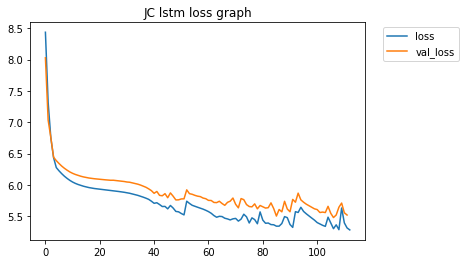

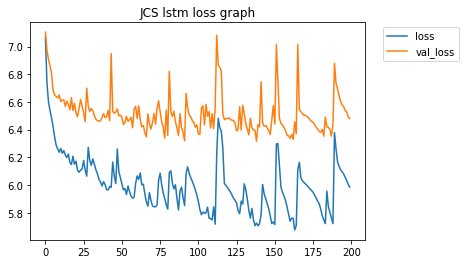

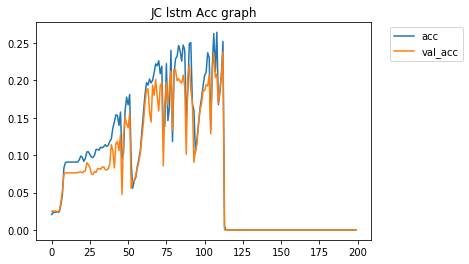

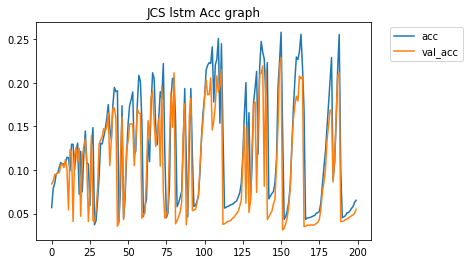

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00      98.0
          11       0.00      0.00      0.00      75.0
          12       0.00      0.00      0.00      69.0
          13       0.00      0.00      0.00     116.0
          14       0.00      0.00      0.00      85.0
          15       0.00      0.00      0.00      56.0
          16       0.00      0.00      0.00      66.0
          17       0.00      0.00      0.00     103.0
          18       0.00      0.00      0.00      69.0
          19       0.00      0.00      0.00      70.0
          20       0.00      0.00      0.00      99.0
          21       0.00      0.00      0.00      67.0
          22       0.00      0.00      0.00      53.0
          23       0.00      0.00      0.00      94.0
          24       0.00      0.00      0.00      66.0
          25       0.00      0.00      0.00      96.0
          26       0.00    

In [0]:
# LSTM model (JC)
lstm_model_position = Sequential()
lstm_model_position.add(LSTM(128, activation='relu', input_shape=model_position_shape))
lstm_model_position.add(Dense(256, activation='relu'))
lstm_model_position.add(Dense(256, activation='relu'))
lstm_model_position.add(Dense(position_total_data[1].shape[-1], activation='relu'))

lstm_model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jc_lstm_200_history.csv', append=True, separator=';')

position_history = lstm_model_position.fit(position_total_data[0][training_index], position_total_data[1][training_index],
                                      epochs= 200,
                                      validation_data=(position_total_data[0][validation_index],
                                                       position_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_position.to_json()
with open("./model_save/jc_lstm_model_200.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_position.save_weights("./model_save/jc_lstm_weight_200.h5")
print("Saved jc lstm model to disk")

###################################################################################################################################
# LSTM model (JCS)
lstm_model_speed = Sequential()
lstm_model_speed.add(LSTM(128, activation='relu', input_shape=model_all_feature_shape))
lstm_model_speed.add(Dense(256, activation='relu'))
lstm_model_speed.add(Dense(256, activation='relu'))
lstm_model_speed.add(Dense(all_feature_total_data[1].shape[-1], activation='relu'))

lstm_model_speed.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jcs_lstm_200_history.csv', append=True, separator=';')

lstm_speed_history = lstm_model_speed.fit(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],
                                            epochs=200,
                                            validation_data=(all_feature_total_data[0][validation_index],
                                                             all_feature_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_speed.to_json()
with open("./model_save/jcs_lstm_model_200.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_speed.save_weights("./model_save/jcs_lstm_weight_200.h5")
print("Saved jc lstm model to disk")


###################################################################################################################################
# Print output
JC_loss = plotting_history_loss(position_history, 'JC lstm loss graph')
JCS_loss = plotting_history_loss(lstm_speed_history, 'JCS lstm loss graph')

JC_1dcnn_acc = plotting_history_acc(position_history, 'JC lstm Acc graph')
JCS_1dcnn_acc = plotting_history_acc(lstm_speed_history, 'JCS lstm Acc graph')

from sklearn.metrics import classification_report

# JC_training
print(classification_report(numpy.argmax(position_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(position_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][validation_index]), axis=1)))
# JCS_training
print(classification_report(numpy.argmax(all_feature_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(all_feature_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][validation_index]), axis=1)))

**Epoch 250**

Train on 3096 samples, validate on 1858 samples
Epoch 1/250
3096/3096 [==============================] - 9s 3ms/step - loss: 7.4582 - acc: 0.0132 - val_loss: 7.5489 - val_acc: 0.0135
Epoch 2/250
3096/3096 [==============================] - 5s 1ms/step - loss: 7.1350 - acc: 0.0113 - val_loss: 7.4310 - val_acc: 0.0102
Epoch 3/250
3096/3096 [==============================] - 4s 1ms/step - loss: 7.0453 - acc: 0.0103 - val_loss: 7.3640 - val_acc: 0.0102
Epoch 4/250
3096/3096 [==============================] - 4s 1ms/step - loss: 6.9871 - acc: 0.0103 - val_loss: 7.3001 - val_acc: 0.0102
Epoch 5/250
3096/3096 [==============================] - 4s 1ms/step - loss: 6.9304 - acc: 0.0100 - val_loss: 7.2362 - val_acc: 0.0097
Epoch 6/250
3096/3096 [==============================] - 5s 1ms/step - loss: 6.8721 - acc: 0.0090 - val_loss: 7.1877 - val_acc: 0.0124
Epoch 7/250
3096/3096 [==============================] - 4s 1ms/step - loss: 6.8104 - acc: 0.0097 - val_loss: 7.1431 - val_acc: 0.0129
Epoch 8

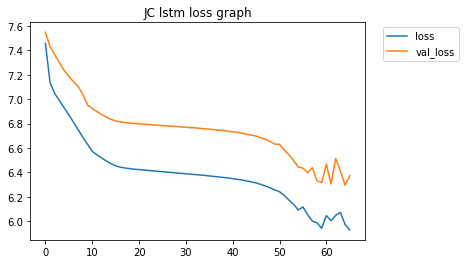

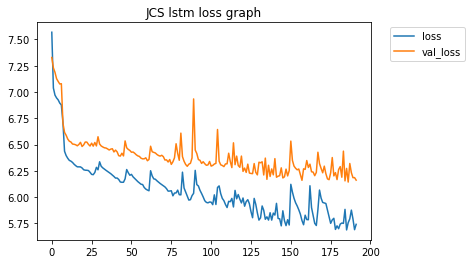

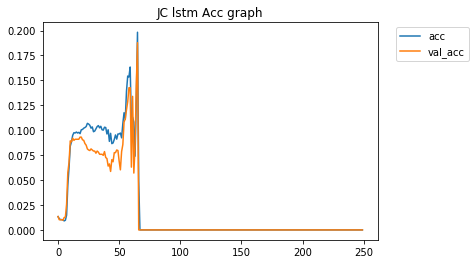

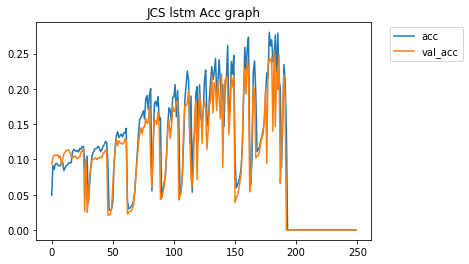

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00      98.0
          11       0.00      0.00      0.00      75.0
          12       0.00      0.00      0.00      69.0
          13       0.00      0.00      0.00     116.0
          14       0.00      0.00      0.00      85.0
          15       0.00      0.00      0.00      56.0
          16       0.00      0.00      0.00      66.0
          17       0.00      0.00      0.00     103.0
          18       0.00      0.00      0.00      69.0
          19       0.00      0.00      0.00      70.0
          20       0.00      0.00      0.00      99.0
          21       0.00      0.00      0.00      67.0
          22       0.00      0.00      0.00      53.0
          23       0.00      0.00      0.00      94.0
          24       0.00      0.00      0.00      66.0
          25       0.00      0.00      0.00      96.0
          26       0.00    

In [0]:
# LSTM model (JC)
lstm_model_position = Sequential()
lstm_model_position.add(LSTM(128, activation='relu', input_shape=model_position_shape))
lstm_model_position.add(Dense(256, activation='relu'))
lstm_model_position.add(Dense(256, activation='relu'))
lstm_model_position.add(Dense(position_total_data[1].shape[-1], activation='relu'))

lstm_model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jc_lstm_250_history.csv', append=True, separator=';')

position_history = lstm_model_position.fit(position_total_data[0][training_index], position_total_data[1][training_index],
                                      epochs= 250,
                                      validation_data=(position_total_data[0][validation_index],
                                                       position_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_position.to_json()
with open("./model_save/jc_lstm_model_250.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_position.save_weights("./model_save/jc_lstm_weight_250.h5")
print("Saved jc lstm model to disk")

###################################################################################################################################
# LSTM model (JCS)
lstm_model_speed = Sequential()
lstm_model_speed.add(LSTM(128, activation='relu', input_shape=model_all_feature_shape))
lstm_model_speed.add(Dense(256, activation='relu'))
lstm_model_speed.add(Dense(256, activation='relu'))
lstm_model_speed.add(Dense(all_feature_total_data[1].shape[-1], activation='relu'))

lstm_model_speed.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jcs_lstm_250_history.csv', append=True, separator=';')

lstm_speed_history = lstm_model_speed.fit(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],
                                            epochs=250,
                                            validation_data=(all_feature_total_data[0][validation_index],
                                                             all_feature_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_speed.to_json()
with open("./model_save/jcs_lstm_model_250.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_speed.save_weights("./model_save/jcs_lstm_weight_250.h5")
print("Saved jc lstm model to disk")


###################################################################################################################################
# Print output
JC_loss = plotting_history_loss(position_history, 'JC lstm loss graph')
JCS_loss = plotting_history_loss(lstm_speed_history, 'JCS lstm loss graph')

JC_1dcnn_acc = plotting_history_acc(position_history, 'JC lstm Acc graph')
JCS_1dcnn_acc = plotting_history_acc(lstm_speed_history, 'JCS lstm Acc graph')

from sklearn.metrics import classification_report

# JC_training
print(classification_report(numpy.argmax(position_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(position_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][validation_index]), axis=1)))
# JCS_training
print(classification_report(numpy.argmax(all_feature_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(all_feature_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][validation_index]), axis=1)))

**Epoch 300**

Train on 3096 samples, validate on 1858 samples
Epoch 1/300
3096/3096 [==============================] - 8s 3ms/step - loss: 8.5345 - acc: 0.0239 - val_loss: 7.7714 - val_acc: 0.0280
Epoch 2/300
3096/3096 [==============================] - 5s 1ms/step - loss: 7.4649 - acc: 0.0536 - val_loss: 7.6113 - val_acc: 0.0662
Epoch 3/300
3096/3096 [==============================] - 4s 1ms/step - loss: 7.3735 - acc: 0.0840 - val_loss: 7.5470 - val_acc: 0.0770
Epoch 4/300
3096/3096 [==============================] - 4s 1ms/step - loss: 7.3193 - acc: 0.0943 - val_loss: 7.4960 - val_acc: 0.0797
Epoch 5/300
3096/3096 [==============================] - 4s 1ms/step - loss: 7.2727 - acc: 0.0972 - val_loss: 7.4547 - val_acc: 0.0791
Epoch 6/300
3096/3096 [==============================] - 4s 1ms/step - loss: 7.2331 - acc: 0.0963 - val_loss: 7.4210 - val_acc: 0.0786
Epoch 7/300
3096/3096 [==============================] - 4s 1ms/step - loss: 7.1991 - acc: 0.0963 - val_loss: 7.3918 - val_acc: 0.0786
Epoch 8

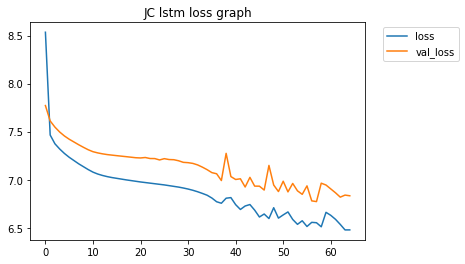

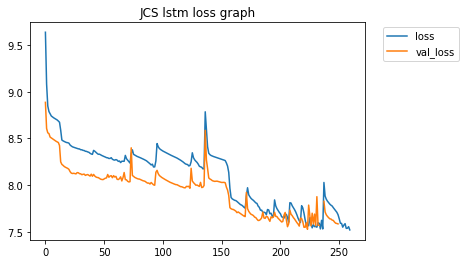

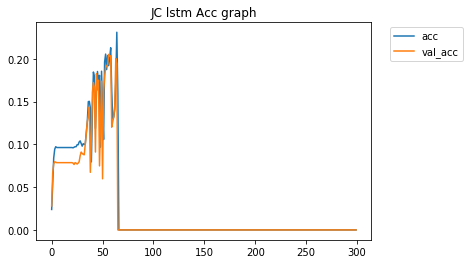

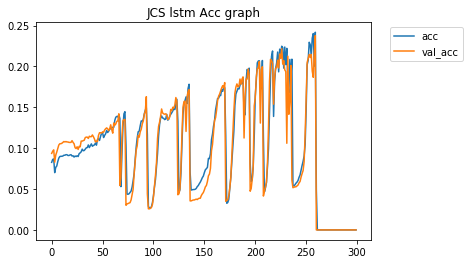

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00      98.0
          11       0.00      0.00      0.00      75.0
          12       0.00      0.00      0.00      69.0
          13       0.00      0.00      0.00     116.0
          14       0.00      0.00      0.00      85.0
          15       0.00      0.00      0.00      56.0
          16       0.00      0.00      0.00      66.0
          17       0.00      0.00      0.00     103.0
          18       0.00      0.00      0.00      69.0
          19       0.00      0.00      0.00      70.0
          20       0.00      0.00      0.00      99.0
          21       0.00      0.00      0.00      67.0
          22       0.00      0.00      0.00      53.0
          23       0.00      0.00      0.00      94.0
          24       0.00      0.00      0.00      66.0
          25       0.00      0.00      0.00      96.0
          26       0.00    

In [0]:
# LSTM model (JC)
lstm_model_position = Sequential()
lstm_model_position.add(LSTM(128, activation='relu', input_shape=model_position_shape))
lstm_model_position.add(Dense(256, activation='relu'))
lstm_model_position.add(Dense(256, activation='relu'))
lstm_model_position.add(Dense(position_total_data[1].shape[-1], activation='relu'))

lstm_model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jc_lstm_300_history.csv', append=True, separator=';')

position_history = lstm_model_position.fit(position_total_data[0][training_index], position_total_data[1][training_index],
                                      epochs= 300,
                                      validation_data=(position_total_data[0][validation_index],
                                                       position_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_position.to_json()
with open("./model_save/jc_lstm_model_300.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_position.save_weights("./model_save/jc_lstm_weight_300.h5")
print("Saved jc lstm model to disk")

###################################################################################################################################
# LSTM model (JCS)
lstm_model_speed = Sequential()
lstm_model_speed.add(LSTM(128, activation='relu', input_shape=model_all_feature_shape))
lstm_model_speed.add(Dense(256, activation='relu'))
lstm_model_speed.add(Dense(256, activation='relu'))
lstm_model_speed.add(Dense(all_feature_total_data[1].shape[-1], activation='relu'))

lstm_model_speed.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jcs_lstm_300_history.csv', append=True, separator=';')

lstm_speed_history = lstm_model_speed.fit(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],
                                            epochs=300,
                                            validation_data=(all_feature_total_data[0][validation_index],
                                                             all_feature_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_speed.to_json()
with open("./model_save/jcs_lstm_model_300.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_speed.save_weights("./model_save/jcs_lstm_weight_300.h5")
print("Saved jc lstm model to disk")


###################################################################################################################################
# Print output
JC_loss = plotting_history_loss(position_history, 'JC lstm loss graph')
JCS_loss = plotting_history_loss(lstm_speed_history, 'JCS lstm loss graph')

JC_1dcnn_acc = plotting_history_acc(position_history, 'JC lstm Acc graph')
JCS_1dcnn_acc = plotting_history_acc(lstm_speed_history, 'JCS lstm Acc graph')

from sklearn.metrics import classification_report

# JC_training
print(classification_report(numpy.argmax(position_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(position_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][validation_index]), axis=1)))
# JCS_training
print(classification_report(numpy.argmax(all_feature_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(all_feature_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][validation_index]), axis=1)))

**Epoch 300_leakyReLU**

Train on 3096 samples, validate on 1858 samples
Epoch 1/300
3096/3096 [==============================] - 8s 3ms/step - loss: 3.5484 - acc: 0.0694 - val_loss: 3.5438 - val_acc: 0.0727
Epoch 2/300
3096/3096 [==============================] - 5s 2ms/step - loss: 3.5342 - acc: 0.0904 - val_loss: 3.5290 - val_acc: 0.0737
Epoch 3/300
3096/3096 [==============================] - 5s 2ms/step - loss: 3.5187 - acc: 0.0908 - val_loss: 3.5123 - val_acc: 0.0737
Epoch 4/300
3096/3096 [==============================] - 5s 2ms/step - loss: 3.5006 - acc: 0.0908 - val_loss: 3.4922 - val_acc: 0.0737
Epoch 5/300
3096/3096 [==============================] - 5s 2ms/step - loss: 3.4780 - acc: 0.0908 - val_loss: 3.4668 - val_acc: 0.0737
Epoch 6/300
3096/3096 [==============================] - 5s 2ms/step - loss: 3.4489 - acc: 0.0908 - val_loss: 3.4336 - val_acc: 0.0737
Epoch 7/300
3096/3096 [==============================] - 5s 2ms/step - loss: 3.4107 - acc: 0.0908 - val_loss: 3.3903 - val_acc: 0.0737
Epoch 8

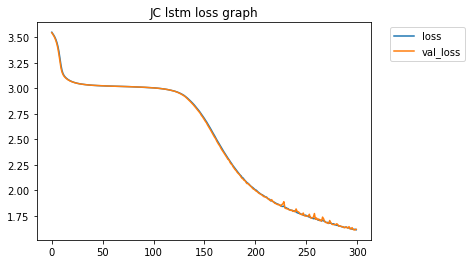

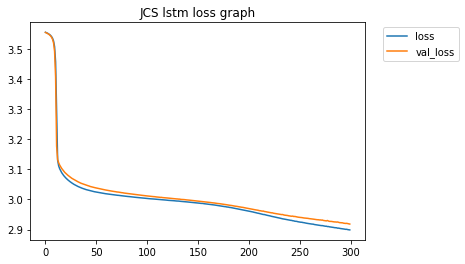

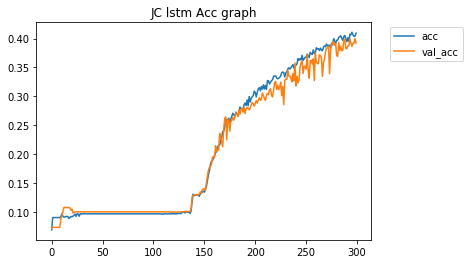

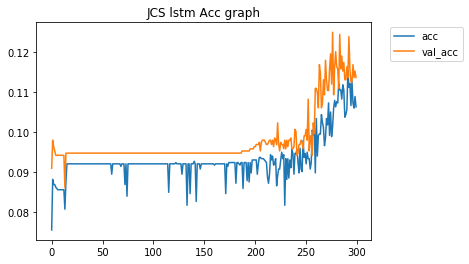

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          10       0.35      0.41      0.38        92
          11       0.48      0.78      0.59        77
          12       0.36      0.11      0.17        74
          13       0.41      0.43      0.42       122
          14       0.00      0.00      0.00        58
          15       0.41      0.14      0.21        83
          16       0.00      0.00      0.00        63
          17       0.64      0.19      0.29       111
          18       0.33      0.06      0.10        71
          19       0.84      0.69      0.76        74
          20       0.48      0.96      0.64       100
          21       0.36      0.14      0.20        93
          22       0.00      0.00      0.00        37
          23       0.69      1.00      0.82        86
          24       0.57      0.94      0.71        62
          25       0.39      1.00      0.56       101
          26       0.00      0.00      0.00        52
          27       0.33    

In [0]:
# LSTM model (JC)
lstm_model_position = Sequential()
lstm_model_position.add(LSTM(128, input_shape=model_position_shape))
lstm_model_position.add(LeakyReLU(0.3))
lstm_model_position.add(Dense(256))
lstm_model_position.add(LeakyReLU(0.3))
lstm_model_position.add(Dense(256))
lstm_model_position.add(LeakyReLU(0.4))
lstm_model_position.add(Dense(position_total_data[1].shape[-1], activation='softmax'))


lstm_model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jc_lstm_lky_300_history.csv', append=True, separator=';')

position_history = lstm_model_position.fit(position_total_data[0][training_index], position_total_data[1][training_index],
                                      epochs= 300,
                                      validation_data=(position_total_data[0][validation_index],
                                                       position_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_position.to_json()
with open("./model_save/jc_lstm_model_lky_300.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_position.save_weights("./model_save/jc_lstm_lky_weight_300.h5")
print("Saved jc lstm model to disk")

###################################################################################################################################
# LSTM model (JCS)
lstm_model_speed = Sequential()
lstm_model_speed.add(LSTM(128, input_shape=model_all_feature_shape))
lstm_model_speed.add(LeakyReLU(0.3))
lstm_model_speed.add(Dense(256))
lstm_model_speed.add(LeakyReLU(0.3))
lstm_model_speed.add(Dense(256))
lstm_model_speed.add(LeakyReLU(0.4))
lstm_model_speed.add(Dense(all_feature_total_data[1].shape[-1], activation='softmax'))


lstm_model_speed.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jcs_lstm_lky_300_history.csv', append=True, separator=';')

lstm_speed_history = lstm_model_speed.fit(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],
                                            epochs=300,
                                            validation_data=(all_feature_total_data[0][validation_index],
                                                             all_feature_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_speed.to_json()
with open("./model_save/jcs_lstm_model_lky_300.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_speed.save_weights("./model_save/jcs_lstm_lky_weight_300.h5")
print("Saved jc lstm model to disk")


###################################################################################################################################
# Print output
JC_loss = plotting_history_loss(position_history, 'JC lstm loss graph')
JCS_loss = plotting_history_loss(lstm_speed_history, 'JCS lstm loss graph')

JC_1dcnn_acc = plotting_history_acc(position_history, 'JC lstm Acc graph')
JCS_1dcnn_acc = plotting_history_acc(lstm_speed_history, 'JCS lstm Acc graph')

from sklearn.metrics import classification_report

# JC_training
print(classification_report(numpy.argmax(position_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(position_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][validation_index]), axis=1)))
# JCS_training
print(classification_report(numpy.argmax(all_feature_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(all_feature_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][validation_index]), axis=1)))

**Epoch 200_Leaky**

Train on 3096 samples, validate on 1858 samples
Epoch 1/200
3096/3096 [==============================] - 7s 2ms/step - loss: 3.5484 - acc: 0.0801 - val_loss: 3.5415 - val_acc: 0.0770
Epoch 2/200
3096/3096 [==============================] - 5s 1ms/step - loss: 3.5319 - acc: 0.0807 - val_loss: 3.5248 - val_acc: 0.0770
Epoch 3/200
3096/3096 [==============================] - 5s 2ms/step - loss: 3.5145 - acc: 0.0807 - val_loss: 3.5065 - val_acc: 0.0770
Epoch 4/200
3096/3096 [==============================] - 5s 1ms/step - loss: 3.4948 - acc: 0.0807 - val_loss: 3.4855 - val_acc: 0.0770
Epoch 5/200
3096/3096 [==============================] - 5s 1ms/step - loss: 3.4716 - acc: 0.0807 - val_loss: 3.4609 - val_acc: 0.0770
Epoch 6/200
3096/3096 [==============================] - 5s 1ms/step - loss: 3.4447 - acc: 0.0807 - val_loss: 3.4317 - val_acc: 0.0770
Epoch 7/200
3096/3096 [==============================] - 5s 1ms/step - loss: 3.4113 - acc: 0.0807 - val_loss: 3.3946 - val_acc: 0.0770
Epoch 8

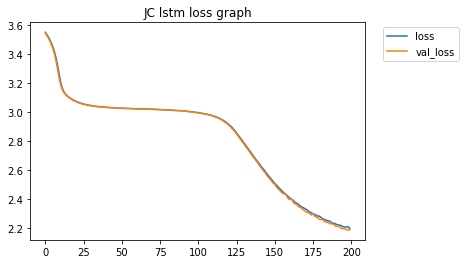

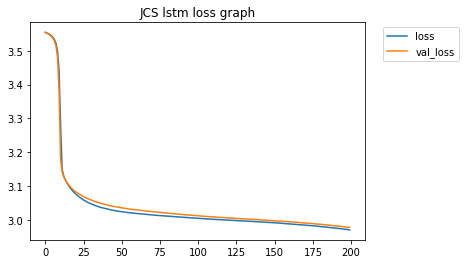

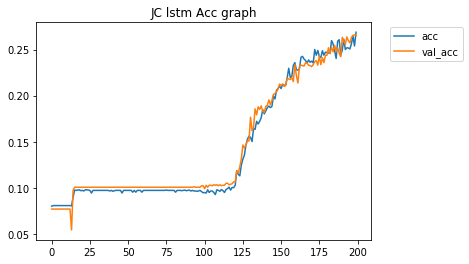

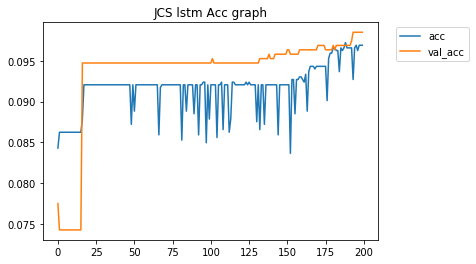

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          10       0.20      0.01      0.02        92
          11       0.00      0.00      0.00        77
          12       0.00      0.00      0.00        74
          13       0.19      0.61      0.29       122
          14       0.00      0.00      0.00        58
          15       0.00      0.00      0.00        83
          16       0.00      0.00      0.00        63
          17       0.00      0.00      0.00       111
          18       0.00      0.00      0.00        71
          19       0.00      0.00      0.00        74
          20       0.00      0.00      0.00       100
          21       0.00      0.00      0.00        93
          22       0.00      0.00      0.00        37
          23       0.57      0.98      0.72        86
          24       0.00      0.00      0.00        62
          25       0.17      1.00      0.29       101
          26       0.00      0.00      0.00        52
          27       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00        90
          11       0.00      0.00      0.00        78
          12       0.00      0.00      0.00        63
          13       0.00      0.00      0.00       114
          14       0.00      0.00      0.00        82
          15       0.00      0.00      0.00       104
          16       0.00      0.00      0.00        54
          17       0.25      0.10      0.15       117
          18       0.00      0.00      0.00        64
          19       0.00      0.00      0.00        63
          20       0.00      0.00      0.00        92
          21       0.00      0.00      0.00        93
          22       0.25      0.05      0.08        63
          23       0.00      0.00      0.00        92
          24       0.00      0.00      0.00        52
          25       0.00    

In [0]:
# LSTM model (JC)
lstm_model_position = Sequential()
lstm_model_position.add(LSTM(128, input_shape=model_position_shape))
lstm_model_position.add(LeakyReLU(0.3))
lstm_model_position.add(Dense(256))
lstm_model_position.add(LeakyReLU(0.3))
lstm_model_position.add(Dense(256))
lstm_model_position.add(LeakyReLU(0.4))
lstm_model_position.add(Dense(position_total_data[1].shape[-1], activation='softmax'))


lstm_model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jc_lstm_lky_200_history.csv', append=True, separator=';')

position_history = lstm_model_position.fit(position_total_data[0][training_index], position_total_data[1][training_index],
                                      epochs= 200,
                                      validation_data=(position_total_data[0][validation_index],
                                                       position_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_position.to_json()
with open("./model_save/jc_lstm_model_lky_200.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_position.save_weights("./model_save/jc_lstm_lky_weight_200.h5")
print("Saved jc lstm model to disk")

###################################################################################################################################
# LSTM model (JCS)
lstm_model_speed = Sequential()
lstm_model_speed.add(LSTM(128, input_shape=model_all_feature_shape))
lstm_model_speed.add(LeakyReLU(0.3))
lstm_model_speed.add(Dense(256))
lstm_model_speed.add(LeakyReLU(0.3))
lstm_model_speed.add(Dense(256))
lstm_model_speed.add(LeakyReLU(0.4))
lstm_model_speed.add(Dense(all_feature_total_data[1].shape[-1], activation='softmax'))


lstm_model_speed.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jcs_lstm_lky_200_history.csv', append=True, separator=';')

lstm_speed_history = lstm_model_speed.fit(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],
                                            epochs=200,
                                            validation_data=(all_feature_total_data[0][validation_index],
                                                             all_feature_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_speed.to_json()
with open("./model_save/jcs_lstm_model_lky_200.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_speed.save_weights("./model_save/jcs_lstm_lky_weight_200.h5")
print("Saved jc lstm model to disk")


###################################################################################################################################
# Print output
JC_loss = plotting_history_loss(position_history, 'JC lstm loss graph')
JCS_loss = plotting_history_loss(lstm_speed_history, 'JCS lstm loss graph')

JC_1dcnn_acc = plotting_history_acc(position_history, 'JC lstm Acc graph')
JCS_1dcnn_acc = plotting_history_acc(lstm_speed_history, 'JCS lstm Acc graph')

from sklearn.metrics import classification_report

# JC_training
print(classification_report(numpy.argmax(position_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(position_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][validation_index]), axis=1)))
# JCS_training
print(classification_report(numpy.argmax(all_feature_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(all_feature_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][validation_index]), axis=1)))

**Epoch 250_Leaky**

Train on 3096 samples, validate on 1858 samples
Epoch 1/250
3096/3096 [==============================] - 7s 2ms/step - loss: 3.5351 - acc: 0.0620 - val_loss: 3.5270 - val_acc: 0.0700
Epoch 2/250
3096/3096 [==============================] - 5s 2ms/step - loss: 3.5181 - acc: 0.0685 - val_loss: 3.5093 - val_acc: 0.0791
Epoch 3/250
3096/3096 [==============================] - 5s 1ms/step - loss: 3.4993 - acc: 0.0753 - val_loss: 3.4890 - val_acc: 0.0797
Epoch 4/250
3096/3096 [==============================] - 5s 2ms/step - loss: 3.4771 - acc: 0.0753 - val_loss: 3.4644 - val_acc: 0.0813
Epoch 5/250
3096/3096 [==============================] - 5s 1ms/step - loss: 3.4500 - acc: 0.0743 - val_loss: 3.4341 - val_acc: 0.0818
Epoch 6/250
3096/3096 [==============================] - 5s 2ms/step - loss: 3.4161 - acc: 0.0872 - val_loss: 3.3964 - val_acc: 0.1033
Epoch 7/250
3096/3096 [==============================] - 5s 2ms/step - loss: 3.3725 - acc: 0.0950 - val_loss: 3.3462 - val_acc: 0.1028
Epoch 8

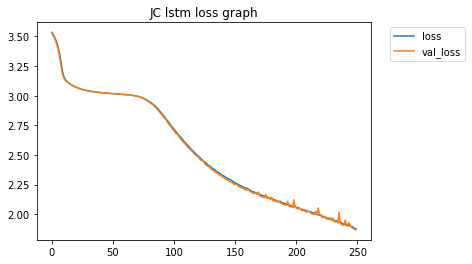

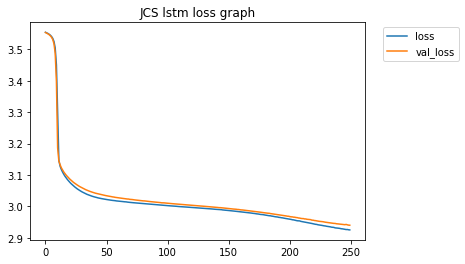

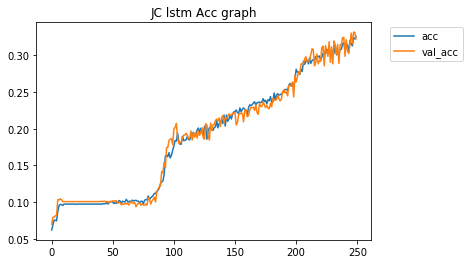

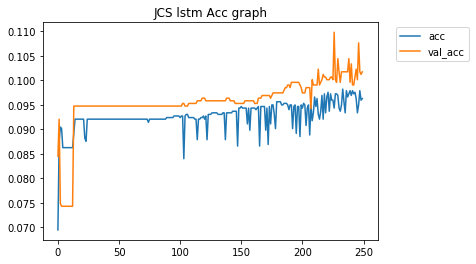

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          10       0.18      0.30      0.23        92
          11       0.19      0.16      0.17        77
          12       0.50      0.09      0.16        74
          13       0.30      0.52      0.38       122
          14       0.00      0.00      0.00        58
          15       0.12      0.04      0.06        83
          16       0.00      0.00      0.00        63
          17       0.52      0.12      0.19       111
          18       0.00      0.00      0.00        71
          19       0.00      0.00      0.00        74
          20       0.43      0.67      0.52       100
          21       0.21      0.10      0.13        93
          22       0.00      0.00      0.00        37
          23       0.57      0.91      0.70        86
          24       0.00      0.00      0.00        62
          25       0.23      1.00      0.37       101
          26       0.00      0.00      0.00        52
          27       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           4       0.00      0.00      0.00         0
          10       0.00      0.00      0.00        90
          11       0.00      0.00      0.00        78
          12       0.00      0.00      0.00        63
          13       0.00      0.00      0.00       114
          14       0.00      0.00      0.00        82
          15       0.00      0.00      0.00       104
          16       0.00      0.00      0.00        54
          17       0.15      0.12      0.13       117
          18       0.00      0.00      0.00        64
          19       0.00      0.00      0.00        63
          20       0.00      0.00      0.00        92
          21       0.00      0.00      0.00        93
          22       0.25      0.11      0.15        63
          23       0.00      0.00      0.00        92
          24       0.00      0.00      0.00        52
          25       0.00      0.00      0.00       105
          26       0.00    

In [0]:
# LSTM model (JC)
lstm_model_position = Sequential()
lstm_model_position.add(LSTM(128, input_shape=model_position_shape))
lstm_model_position.add(LeakyReLU(0.3))
lstm_model_position.add(Dense(256))
lstm_model_position.add(LeakyReLU(0.3))
lstm_model_position.add(Dense(256))
lstm_model_position.add(LeakyReLU(0.4))
lstm_model_position.add(Dense(position_total_data[1].shape[-1], activation='softmax'))


lstm_model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jc_lstm_lky_250_history.csv', append=True, separator=';')

position_history = lstm_model_position.fit(position_total_data[0][training_index], position_total_data[1][training_index],
                                      epochs= 250,
                                      validation_data=(position_total_data[0][validation_index],
                                                       position_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_position.to_json()
with open("./model_save/jc_lstm_model_lky_250.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_position.save_weights("./model_save/jc_lstm_lky_weight_250.h5")
print("Saved jc lstm model to disk")

###################################################################################################################################
# LSTM model (JCS)
lstm_model_speed = Sequential()
lstm_model_speed.add(LSTM(128, input_shape=model_all_feature_shape))
lstm_model_speed.add(LeakyReLU(0.3))
lstm_model_speed.add(Dense(256))
lstm_model_speed.add(LeakyReLU(0.3))
lstm_model_speed.add(Dense(256))
lstm_model_speed.add(LeakyReLU(0.4))
lstm_model_speed.add(Dense(all_feature_total_data[1].shape[-1], activation='softmax'))


lstm_model_speed.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jcs_lstm_lky_250_history.csv', append=True, separator=';')

lstm_speed_history = lstm_model_speed.fit(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],
                                            epochs=250,
                                            validation_data=(all_feature_total_data[0][validation_index],
                                                             all_feature_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_speed.to_json()
with open("./model_save/jcs_lstm_model_lky_250.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_speed.save_weights("./model_save/jcs_lstm_lky_weight_250.h5")
print("Saved jc lstm model to disk")


###################################################################################################################################
# Print output
JC_loss = plotting_history_loss(position_history, 'JC lstm loss graph')
JCS_loss = plotting_history_loss(lstm_speed_history, 'JCS lstm loss graph')

JC_1dcnn_acc = plotting_history_acc(position_history, 'JC lstm Acc graph')
JCS_1dcnn_acc = plotting_history_acc(lstm_speed_history, 'JCS lstm Acc graph')

from sklearn.metrics import classification_report

# JC_training
print(classification_report(numpy.argmax(position_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(position_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][validation_index]), axis=1)))
# JCS_training
print(classification_report(numpy.argmax(all_feature_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(all_feature_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][validation_index]), axis=1)))

**Epoch 4000 Leaky**

In [27]:
# LSTM model (JC)
lstm_model_position = Sequential()
lstm_model_position.add(LSTM(128, input_shape=model_position_shape))
lstm_model_position.add(LeakyReLU(0.3))
lstm_model_position.add(Dense(256))
lstm_model_position.add(LeakyReLU(0.3))
lstm_model_position.add(Dense(256))
lstm_model_position.add(LeakyReLU(0.4))
lstm_model_position.add(Dense(position_total_data[1].shape[-1], activation='softmax'))


lstm_model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./model_save/jc_lstm_lky_4000_history.csv', append=True, separator=';')

position_history = lstm_model_position.fit(position_total_data[0][training_index], position_total_data[1][training_index],
                                      epochs=4000,
                                      validation_data=(position_total_data[0][validation_index],
                                                       position_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = lstm_model_position.to_json()
with open("./model_save/jc_lstm_model_lky_4000.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
lstm_model_position.save_weights("./model_save/jc_lstm_lky_weight_4000.h5")
print("Saved jc lstm model to disk")

###################################################################################################################################
# # LSTM model (JCS)
# lstm_model_speed = Sequential()
# lstm_model_speed.add(LSTM(128, input_shape=model_all_feature_shape))
# lstm_model_speed.add(LeakyReLU(0.3))
# lstm_model_speed.add(Dense(256))
# lstm_model_speed.add(LeakyReLU(0.3))
# lstm_model_speed.add(Dense(256))
# lstm_model_speed.add(LeakyReLU(0.4))
# lstm_model_speed.add(Dense(all_feature_total_data[1].shape[-1], activation='softmax'))


# lstm_model_speed.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

# from keras.callbacks import CSVLogger
# csv_logger = CSVLogger('./model_save/jcs_lstm_lky_4000_history.csv', append=True, separator=';')

# lstm_speed_history = lstm_model_speed.fit(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],
#                                             epochs=4000,
#                                             validation_data=(all_feature_total_data[0][validation_index],
#                                                              all_feature_total_data[1][validation_index]), callbacks=[csv_logger])

# # model save
# model_json = lstm_model_speed.to_json()
# with open("./model_save/jcs_lstm_model_lky_4000.json", "w") as json_file : 
#     json_file.write(model_json)
    
# # model weight save
# lstm_model_speed.save_weights("./model_save/jcs_lstm_lky_weight_4000.h5")
# print("Saved jc lstm model to disk")


###################################################################################################################################
# Print output
JC_loss = plotting_history_loss(position_history, 'JC lstm loss graph')
# JCS_loss = plotting_history_loss(lstm_speed_history, 'JCS lstm loss graph')

JC_1dcnn_acc = plotting_history_acc(position_history, 'JC lstm Acc graph')
# JCS_1dcnn_acc = plotting_history_acc(lstm_speed_history, 'JCS lstm Acc graph')

from sklearn.metrics import classification_report

# JC_training
print(classification_report(numpy.argmax(position_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(position_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][validation_index]), axis=1)))
# JCS_training
# print(classification_report(numpy.argmax(all_feature_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][training_index]), axis=1)))
# print(classification_report(numpy.argmax(all_feature_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_speed.predict(all_feature_total_data[0][validation_index]), axis=1)))

Train on 3096 samples, validate on 1858 samples
Epoch 1/4000
2656/3096 [========================>.....] - ETA: 0s - loss: 3.5508 - acc: 0.0870

KeyboardInterrupt: ignored

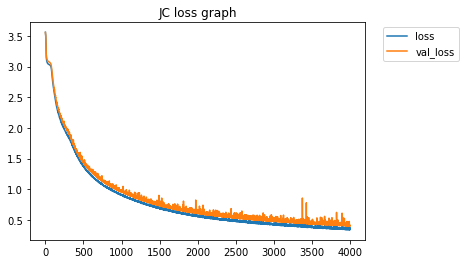

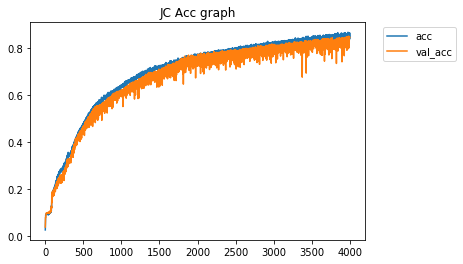

In [30]:
JC_loss = plotting_history_loss(position_history, 'JC loss graph')
JC_1dcnn_acc = plotting_history_acc(position_history, 'JC Acc graph')

In [34]:
# jc model load
from keras.models import model_from_json 
json_file = open("./model_save/jc_lstm_model_lky_4000.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# model weight load 
lstm_model_position.load_weights("./model_save/jc_lstm_lky_weight_4000.h5")
print("Loaded model from disk")



from sklearn.metrics import classification_report

# JC_training
print(classification_report(numpy.argmax(position_total_data[1][training_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(position_total_data[1][validation_index], axis=1), numpy.argmax(lstm_model_position.predict(position_total_data[0][validation_index]), axis=1)))


Loaded model from disk
              precision    recall  f1-score   support

          10       1.00      0.98      0.99        82
          11       1.00      1.00      1.00        84
          12       0.97      0.92      0.94        64
          13       0.87      0.94      0.91       109
          14       0.94      0.99      0.96        88
          15       1.00      1.00      1.00       108
          16       0.97      1.00      0.98        64
          17       1.00      0.98      0.99       105
          18       0.89      0.73      0.80        55
          19       1.00      1.00      1.00        71
          20       1.00      1.00      1.00        83
          21       0.98      0.99      0.98        90
          22       0.98      0.94      0.96        68
          23       1.00      1.00      1.00        77
          24       1.00      1.00      1.00        67
          25       1.00      1.00      1.00       111
          26       0.88      0.90      0.89        50
    